***ECE685D Homework #1***

**Dmitrii/Dima Tsvetkov**

**NetID: dt169**

Agreement 1) This assignment represents my own work. I did not work on this assignment with
others. All coding was done by myself.

Agreement 2) I understand that if I struggle with this assignment that I will reevaluate whether
this is the correct class for me to take. I understand that the homework only gets harder.




***Problem 1: Linear regression on a simple dataset(30 pts)***
**Part (1)**

In [248]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import struct
from array import array
from os.path import join
import os
import torch
import torch.nn as nn


In [249]:
XY_raw = pd.read_csv('Concrete_Data_Yeh.csv')
XY_raw

,cement,slag,flyash,water,superplasticizer,coarseaggregate,fineaggregate,age,csMPa
0,540.0,0.0,0.0,162.0,2.5,1040.0,676.0,28,79.99
1,540.0,0.0,0.0,162.0,2.5,1055.0,676.0,28,61.89
2,332.5,142.5,0.0,228.0,0.0,932.0,594.0,270,40.27
3,332.5,142.5,0.0,228.0,0.0,932.0,594.0,365,41.05
4,198.6,132.4,0.0,192.0,0.0,978.4,825.5,360,44.30
...,...,...,...,...,...,...,...,...,...
1025,276.4,116.0,90.3,179.6,8.9,870.1,768.3,28,44.28
1026,322.2,0.0,115.6,196.0,10.4,817.9,813.4,28,31.18
1027,148.5,139.4,108.6,192.7,6.1,892.4,780.0,28,23.70
1028,159.1,186.7,0.0,175.6,11.3,989.6,788.9,28,32.77


Processing the data.

In [250]:
X = XY_raw.iloc[:, :-1]
y = XY_raw.iloc[:, -1]

First, let's find the derivatives of MSE loss function with respect to weights (including the bias $\beta_0$).
$$MSE=\frac{1}{N}\sum_{i=1}^{N}(Y_i - X_i\beta - \beta_0)^2,$$
or
$$MSE=\frac{1}{N}||(Y - X\beta - \beta_0)||^2.$$
To further simplify the expression let's put $\beta_0$ into the vector $\beta$. For that, we can add array of 1's into the X as an extra feature. in that case our loss is:
$$MSE=\frac{1}{N}||(Y - X\beta)||^2.$$
Thus, the derivative with respect to weights $\beta$:
$$\frac{\partial MSE}{\partial \beta}=\frac{1}{N}X^T(Y - X\beta).$$
Setting the derivative of MSE to zero (in order to get the minimum) and rearranging it, we can get:
$$\frac{1}{N}X^T(Y - X\beta)=0,$$
$$X^TY=X^TX\beta,$$
and the expression for $\beta$ is
$$\beta=(X^TX)^{-1}X^TY.$$
Let's implement these calculations.

In [251]:
# implementing the bios term into the X array
X_new = X.copy()
X_new['bias'] = np.ones(len(y))

def LR_multi_get_coefficients(X, y):
    """
    getting coefficients for LR using the exact solution of the minimization problem:
    $$\beta=(X^TX)^{-1}X^TY.$$
    """
    XT_X = np.dot(X.T, X)
    XT_X_inv = np.linalg.inv(XT_X)
    XT_X_inv_XT = np.dot(XT_X_inv, X.T)
    beta = np.dot(XT_X_inv_XT, y)
    return beta

def y_predicted(X, beta):
    # calculation of the predicted values using LR
    return np.dot(X, beta.T)

Now, let's use our solution to predict the values $Y$ and calculate MSE.

In [252]:
def MSE(y, y_pred):
    # MSE Loss function for LR
    dif = y - y_pred
    loss = np.dot(dif.T, dif) / len(y)
    return loss

beta = LR_multi_get_coefficients(X_new, y)
y_pred = y_predicted(X_new, beta)

print('First 5 predicted values vs the real values:')
print(f'{list(y[:5])}\n{y_pred[:5]}')
print('*'*80)
print(f'Loss function value: {MSE(y, y_pred)}')
print('*'*80)
print(f'Coefficients \u03B2:\n{beta[:8]}\nBias: {beta[8]}')

First 5 predicted values vs the real values:
[79.99, 61.89, 40.27, 41.05, 44.3]
[53.46346329 53.73475651 56.81258504 67.66368153 60.91205585]
********************************************************************************
Loss function value: 107.19723607486014
********************************************************************************
Coefficients β:
[ 0.11980433  0.10386581  0.08793432 -0.14991842  0.2922246   0.01808621
  0.02019035  0.11422207]
Bias: -23.331213584971355


***************************************
We can do the same with calculation the actual derivatives of MSE function:
$$\frac{\partial MSE}{\partial \beta}=-\frac{2}{N}||Y - X\beta||^T X$$
and using the gradient descent with appropriate learning rates.

In [253]:
def gradient_beta(X, y, beta):
    # d MSE/d beta
    dif = y - y_predicted(X, beta)
    grad = -2 * np.dot(dif.T, X) / len(y)
    return grad

beta2 = np.zeros(np.shape(X_new)[1])
# have to set different learning rates for beta and bias terms, otherwise I need too many steps
learning_rate = 0.0000001
learning_rate_bias = 0.05
for i in range(20000):
    gradient = gradient_beta(X_new, y, beta2)
    beta2[:8] -= learning_rate * gradient[:8]
    beta2[8] -= learning_rate_bias * gradient[8]

We can see, that the second approach is getting close to the exact solution. To get rid of the small difference in the loss function values we, probably, need to preprocess the data (at least normalize all the features to the same diapason) and play with the learning rates.
At least I am happy since it also works.

In [254]:
y_pred2 = y_predicted(X_new, beta2)
print(f'Loss function value (exact solution):\n{MSE(y, y_pred)}')
print(f'Loss function value (gradients):\n{MSE(y, y_pred2)}')

Loss function value (exact solution):
107.19723607486014
Loss function value (gradients):
108.12939203729731


***************************************


**Part (2)**

Let's split the data randomly into the training and test parts.

In [255]:
X_new_shuffles = X_new.copy().sample(frac=1, random_state=1)
y_shuffles = y.copy().sample(frac=1, random_state=1)
index_75 = int(len(y)*0.75)
X_train, X_test = X_new_shuffles[:index_75], X_new_shuffles[index_75:]
y_train, y_test = y_shuffles[:index_75], y_shuffles[index_75:]

Let's randomly choose 6 and 7 independent variables for i={7,8} (We will keep the bias for all 3 models with i={7,8,9}).

In [256]:
beta_m1 = np.arange(9)
rng=np.random.RandomState(4)
beta_m2_no_bias = np.sort(rng.choice(8, 7, replace=False))
beta_m2 = np.concatenate((beta_m2_no_bias, [8]))
beta_m3_no_bias = np.sort(rng.choice(8, 6, replace=False))
beta_m3 = np.concatenate((beta_m3_no_bias, [8]))
print(beta_m1, beta_m2, beta_m3)

[0 1 2 3 4 5 6 7 8] [0 1 3 4 5 6 7 8] [0 3 4 5 6 7 8]


Now let's find coefficients for all 3 models and calculate losses on the test data sets.

In [257]:
beta1 = LR_multi_get_coefficients(X_train.iloc[:, beta_m1], y_train)
y_pred1 = y_predicted(X_test.iloc[:, beta_m1], beta1)
print('9 parameters MSE Loss: ', MSE(y_test, y_pred1))
print('*'*80)
beta2 = LR_multi_get_coefficients(X_train.iloc[:, beta_m2], y_train)
y_pred2 = y_predicted(X_test.iloc[:, beta_m2], beta2)
print('8 parameters MSE Loss: ', MSE(y_test, y_pred2))
print('*'*80)
beta3 = LR_multi_get_coefficients(X_train.iloc[:, beta_m3], y_train)
y_pred3 = y_predicted(X_test.iloc[:, beta_m3], beta3)
print('7 parameters MSE Loss: ', MSE(y_test, y_pred3))


9 parameters MSE Loss:  111.1016164698705
********************************************************************************
8 parameters MSE Loss:  114.18549582524115
********************************************************************************
7 parameters MSE Loss:  123.97931131450241


As we can see, with this data it seems like that the best result can be achieved with the higher number of independent parameters. I've tried it for several random choices of the parameters (was changing rng=np.random.RandomState(4)). This result still stays for that data set. 9 is better than 8, 8 is better than 7.

I believe, models with multiple linear regression that include more independent variables do not always perform better because of the overfitting. However, It seems like the MSE R^2 Error always will be smaller with more independent variables

(found it in several places on the internet. For example here https://stats.stackexchange.com/questions/306267/is-mse-decreasing-with-increasing-number-of-explanatory-variables and https://statisticsbyjim.com/regression/interpret-adjusted-r-squared-predicted-r-squared-regression/). But it does not mean it's better to have more variables even tho MSE is decreasing. It's necessary to look at other metrics as well.

***************************************
***************************************
***Problem2:Multinomial Logistic regression from pre-trained feature extractor(45pts)***
**Step 1**
Loading the pre-trained weight to my feature extractor.

In [258]:
class extractor(nn.Module):
	def __init__(self):
		super().__init__()
		self.conv1 = nn.Sequential(
			nn.Conv2d(1, 16, 5, 1, 2),
			nn.ReLU(), nn.MaxPool2d(kernel_size=2))

		self.conv2 = nn.Sequential(
			nn.Conv2d(16, 32, 5, 1, 2),
			nn.ReLU(), nn.MaxPool2d(2))

		self.dim_redu = nn.Sequential(nn.Linear(32 * 7 * 7, 256), nn.Tanh())

	def forward(self, x):
		N, C, W, H = x.shape
		assert C == 1 and W == 28 and H == 28, 'input tensor should be of dimension N*1*28*28'

		x = self.conv1(x)
		x = self.conv2(x)
		# flatten the output of conv2 to (batch_size, 32 * 7 * 7)
		x = x.view(x.size(0), -1)

		return self.dim_redu(x)

In [259]:
feature_extr = extractor()
feature_extr.load_state_dict(torch.load('feature_extractor_weights.pth'))

<All keys matched successfully>

***************************************
**Step 2**
Reading the files using the standard instruction from the kaggle website (https://www.kaggle.com/code/hojjatk/read-mnist-dataset/notebook)

In [260]:
#
# MNIST Data Loader Class
#
class MnistDataloader(object):
	def __init__(self, training_images_filepath, training_labels_filepath,
	             test_images_filepath, test_labels_filepath):
		self.training_images_filepath = training_images_filepath
		self.training_labels_filepath = training_labels_filepath
		self.test_images_filepath = test_images_filepath
		self.test_labels_filepath = test_labels_filepath
		print()

	def read_images_labels(self, images_filepath, labels_filepath):
		labels = []
		with open(labels_filepath, 'rb') as file:
			magic, size = struct.unpack(">II", file.read(8))
			if magic != 2049:
				raise ValueError('Magic number mismatch, expected 2049, got {}'.format(magic))
			labels = array("B", file.read())

		with open(images_filepath, 'rb') as file:
			magic, size, rows, cols = struct.unpack(">IIII", file.read(16))
			if magic != 2051:
				raise ValueError('Magic number mismatch, expected 2051, got {}'.format(magic))
			image_data = array("B", file.read())
		images = []
		for i in range(size):
			images.append([0] * rows * cols)
		for i in range(size):
			img = np.array(image_data[i * rows * cols:(i + 1) * rows * cols])
			img = img.reshape(28, 28)
			images[i][:] = img

		return images, labels

	def load_data(self):
		x_train, y_train = self.read_images_labels(self.training_images_filepath, self.training_labels_filepath)
		x_test, y_test = self.read_images_labels(self.test_images_filepath, self.test_labels_filepath)
		return (x_train, y_train), (x_test, y_test)

In [261]:
#
# Verify Reading Dataset via MnistDataloader class
# Set file paths based on added MNIST Datasets
#
input_path = 'input/'
training_images_filepath = join(input_path, 'train-images-idx3-ubyte/train-images-idx3-ubyte')
training_labels_filepath = join(input_path, 'train-labels-idx1-ubyte/train-labels-idx1-ubyte')
test_images_filepath = join(input_path, 't10k-images-idx3-ubyte/t10k-images-idx3-ubyte')
test_labels_filepath = join(input_path, 't10k-labels-idx1-ubyte/t10k-labels-idx1-ubyte')

# checking the files myself
if (
		os.path.isfile(training_images_filepath)
		and os.path.isfile(training_labels_filepath)
		and os.path.isfile(test_images_filepath)
		and os.path.isfile(test_labels_filepath)
):
	print('All files are good')
#
# Load MINST dataset
#
mnist_dataloader = MnistDataloader(training_images_filepath, training_labels_filepath, test_images_filepath,
                                   test_labels_filepath)
(x_train, y_train), (x_test, y_test) = mnist_dataloader.load_data()

All files are good



Just collecting some knowledge on the data for myself

60000
10000
(10000, 28, 28)
<class 'list'>
<class 'list'>
<class 'numpy.ndarray'>
7
torch.Size([10000, 1, 28, 28])


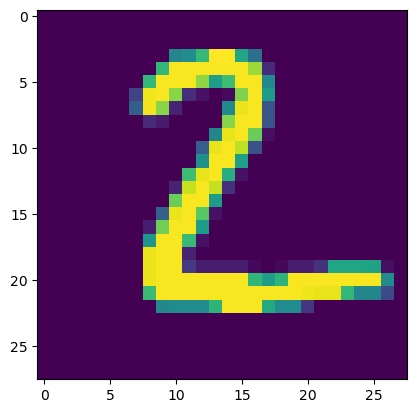

In [262]:
print(len(x_train))
print(len(x_test))
print(np.array(x_test).shape)
print(type(x_test))
print(type(x_test[0]))
print(type(x_test[0][0]))
print(y_test[0])
X_test_T = torch.Tensor(np.array(x_test))[None].reshape(-1, 1, 28, 28)
print(X_test_T.shape)
plt.imshow(X_test_T[1][0])

In [263]:
X_test = feature_extr.forward(X_test_T)
X_train_T = torch.Tensor(np.array(x_train))[None].reshape(-1, 1, 28, 28)
X_train = feature_extr.forward(X_train_T)

torch.Size([10000, 256]) torch.Size([60000, 256])


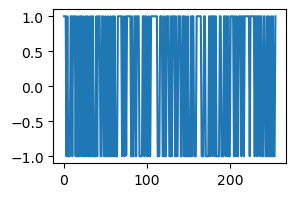

In [264]:
print(X_test.shape, X_train.shape)
plt.figure(figsize=(3, 2))
plt.plot(X_train[0].detach().numpy())

***************************************
**Step 3**
Derive the gradient of W and b w.r.t. the cross-entropy loss.
(Mostly using the lecture #3).
$$y=\sigma(W^Th+b)=\frac{\exp{W_k^Th}}{\sum_i\exp{W_i^Th}},$$
where $\sigma$ is Softmax function.
Let's denote $t$ (real values) in the form of one-hot representation as $T$.
To make the calculation easier let's put bias term into $W$ and $h$. And to emphasize that move we rename $h$ to $X$.
In that case the likelihood is:
$$p(T|X,W)=\prod_{n=1}^N\prod_{k=1}^K y_{nk}^{t_{nk}}$$
(We have N samples and K classes).
Cross-entropy:
$$E(W)=-\ln p(T|X,W)=-\sum_{n=1}^N\sum_{k=1}^K t_{nk}\ln y_{nk},$$


Let's look at the derivative with respect to $W_j$.
$$\frac{\partial E}{\partial W_j}=-\frac{\partial}{\partial W_j}\sum_{n=1}^N\sum_{k=1}^K t_{nk}\ln y_{nk}.$$
For simplicity let's drom the summation over n for now.

$$\frac{\partial E}{\partial W_j}=-\sum_{k=1}^K t_{nk}\frac{\partial}{\partial W_j}\ln y_{nk},$$
$$\frac{\partial E}{\partial W_j}=-\sum_{k=1}^K (t_{nk}\frac{\partial}{\partial W_j}(W_kX_n)-t_{nk}\frac{\partial}{\partial W_j}(\ln{{\sum_i\exp{W_i^TX_n}}})).$$

The first term is not equal to 0 only when $W_j=W_k$, and thus we can remove the summation over k.
$$\frac{\partial E}{\partial W_j}=-t_{nj}X_n+\sum_{k=1}^Kt_{nk}\frac{\partial}{\partial W_j}(\ln{\sum_i\exp{W_i^TX_n}}).$$


Now let's take a look at the second term.
$$\frac{\partial E}{\partial W_j}=-t_{nj}X_n+\sum_{k=1}^Kt_{nk}\frac{1}{\sum_i\exp{W_i^TX_n}}\frac{\partial}{\partial W_j}(\sum_i\exp{W_i^TX_n}).$$
And now we have the similar condition $W_j=W_i$, so we can discard the summation over $i$:
$$\frac{\partial E}{\partial W_j}=-t_{nj}X_n+\sum_{k=1}^Kt_{nk}X_n\frac{1}{\sum_i\exp{W_i^TX_n}}(\exp{W_j^TX_n})=$$
$$=-t_{nj}X_n+y_{nj}X_n\sum_{k=1}^Kt_{nk}.$$
Summation over $k$ of $t_{nk}$ is equal to 1.

In that case we have:
$$\frac{\partial E}{\partial W_j}=y_{nj}X_n-t_{nj}X_n$$
And going back to the summation over $N$ samples we have:
$$\Delta_{W_j} E(W)=\sum_{n=1}^N (y_{nj} - t_{nj})X_n.$$

Implementation of the SGD from scratch. Calculating the gradient.

In [265]:
def Softmax_my(X, dim=1):
	numerator = torch.exp(X)
	denominator = torch.sum(numerator, dim=dim).view(-1, 1)
	print(numerator.shape)
	print(denominator.shape)
	return torch.div(numerator, denominator)

num_classes = len(np.unique(y_train))
num_train = len(y_train)
num_test = len(y_test)
SM = nn.Softmax(dim=1)
y_train_oh = torch.nn.functional.one_hot(torch.tensor(y_train), num_classes=num_classes).float()
y_test_oh = torch.nn.functional.one_hot(torch.tensor(y_test), num_classes=num_classes).float()

def prediction(X, W, b):
	return SM(torch.matmul(W, X.T).T + b)

def cross_entropy_loss(X, y_oh, W, b):
	return -torch.trace(torch.matmul(torch.log(prediction(X, W, b)).T, y_oh))

def gradient_W_and_b(X, y_oh, W, b):
	temp_calc = (prediction(X, W, b) - y_oh).T
	grad_W = torch.matmul(temp_calc, X)
	x_bias = torch.ones(X.shape[0])
	grad_b = torch.matmul(temp_calc, x_bias)
	return grad_W, grad_b


Running SGD and plotting the Loss for the training and test data. W abd b are initialized with 0 values (maybe not the best idea but in that case it works well. It converges)

In [266]:
batch_size = 2 ** 8
b = torch.zeros(num_classes)
W = torch.zeros((num_classes, X_test.shape[1]))
epochs = 401
learning_rate = 0.000001
learning_rate_bias = 0.000001
epochs_plot = []
losses_train = []
losses_test = []
loss_train = cross_entropy_loss(X_train, y_train_oh, W, b).item()
loss_test = cross_entropy_loss(X_test, y_test_oh, W, b).item()
predictions = np.array(prediction(X_test, W, b).max(dim=1).indices)
score = 1 - np.count_nonzero(predictions - y_test) / num_test
print(f'epoch: {0}; loss (train): {loss_train:.2f}; loss (test): {loss_test:.2f}; score: {score * 100:2.2f}%')
with torch.no_grad():  # otherwise I do not have enough memory.
	for epoch in range(epochs):
		# randomizing indexes for batches
		batch_order = np.random.choice(num_train, num_train)
		for i in range(num_train // batch_size):
			ind = batch_order[batch_size * i: batch_size * (i + 1)]
			gW, gb = gradient_W_and_b(X_train[ind], y_train_oh[ind], W, b)
			W -= learning_rate * gW
			b -= learning_rate_bias * gb
		# extra items not in batches (leftovers)
		ind = batch_order[batch_size * (num_train // batch_size): ]
		gW, gb = gradient_W_and_b(X_train[ind], y_train_oh[ind], W, b)
		W -= learning_rate * gW
		b -= learning_rate_bias * gb
		if (not epoch % 20) and (epoch != 0):
			epochs_plot.append(epoch)
			loss_train = cross_entropy_loss(X_train, y_train_oh, W, b).item()
			loss_test = cross_entropy_loss(X_test, y_test_oh, W, b).item()
			predictions = np.array(prediction(X_test, W, b).max(dim=1).indices)
			score = 1 - np.count_nonzero(predictions - y_test) / num_test
			print(f'epoch: {epoch}; loss (train): {loss_train:.2f}; loss (test): {loss_test:.2f}; score: {score * 100:2.2f}%')
			losses_train.append(loss_train)
			losses_test.append(loss_test)


epoch: 0; loss (train): 138160.69; loss (test): 23025.92; score: 9.80%
epoch: 20; loss (train): 12000.54; loss (test): 2046.56; score: 98.28%
epoch: 40; loss (train): 7110.71; loss (test): 1272.63; score: 98.42%
epoch: 60; loss (train): 5343.50; loss (test): 1000.49; score: 98.45%
epoch: 80; loss (train): 4394.23; loss (test): 857.72; score: 98.54%
epoch: 100; loss (train): 3786.48; loss (test): 767.94; score: 98.60%
epoch: 120; loss (train): 3358.54; loss (test): 705.61; score: 98.61%
epoch: 140; loss (train): 3035.29; loss (test): 659.12; score: 98.66%
epoch: 160; loss (train): 2782.57; loss (test): 623.21; score: 98.69%
epoch: 180; loss (train): 2577.43; loss (test): 594.42; score: 98.70%
epoch: 200; loss (train): 2406.88; loss (test): 570.63; score: 98.71%
epoch: 220; loss (train): 2262.46; loss (test): 550.65; score: 98.72%
epoch: 240; loss (train): 2137.87; loss (test): 533.56; score: 98.72%
epoch: 260; loss (train): 2029.25; loss (test): 518.78; score: 98.73%
epoch: 280; loss (t

400 epochs is enough for score close to 99%.

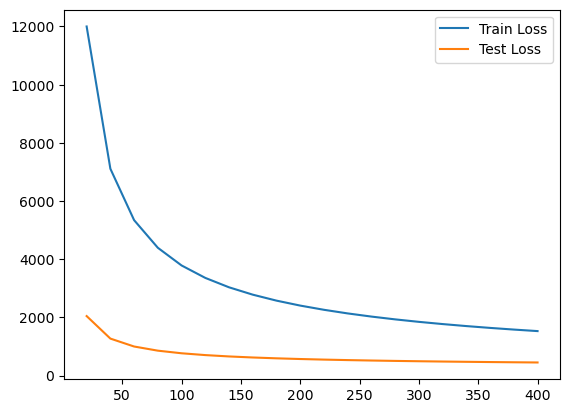

In [267]:

plt.plot(epochs_plot, losses_train, label='Train Loss')
plt.plot(epochs_plot, losses_test, label='Test Loss')
plt.legend()
plt.show()

In [268]:
print(W, b)

tensor([[-0.0182, -0.0065, -0.0805,  ...,  0.0537,  0.0255,  0.0758],
        [-0.0649, -0.0587,  0.0371,  ..., -0.0685,  0.0389, -0.0427],
        [-0.0731,  0.0321, -0.0230,  ..., -0.0863,  0.0600, -0.0480],
        ...,
        [ 0.0490,  0.0699, -0.0907,  ..., -0.0241,  0.0057, -0.0004],
        [ 0.0751, -0.0125, -0.0231,  ...,  0.0400,  0.0149, -0.0693],
        [ 0.0229, -0.0650,  0.0744,  ..., -0.0664,  0.0490,  0.1205]]) tensor([ 0.0004,  0.0103,  0.0018, -0.0063, -0.0082,  0.0099, -0.0016, -0.0042,
        -0.0025,  0.0003])


***************************************
***************************************
***Problem 3: Transformation from a uniform distribution (25pts)***

The Box-Muller transform:
$$U_1=Uniform(0,1),~~ U_2=Uniform(0,1),$$
$$\Theta=2\pi U_1,~~ R=\sqrt{-2\ln(U_2)}.$$
Need to show that
$$Z=(R\cos(\Theta),R|sin(\Theta))^T$$
follows a standard bivariate normal distribution:
$$Z\sim N(0,\rho)=\frac{1}{2\pi\sqrt{1-\rho^2}}e^{-\frac{x^2+y^2}{2(1-\rho^2)}}.$$
if we look at the case $\rho=1$ we getting
$$N(x,y)=\frac{1}{2\pi}e^{-\frac{x^2+y^2}{2}}.$$

We need to show, the gaussian distribution can be represented via 2 uniform distributions $U_1$ and $U_2$.

To show that, we can use the fact that the probability $N(x,y)dxdy$ should be unchanged with any coordinate transformations.
First, let's use the transformation to polar coordinates:
$$x=r\cos(\theta),~~y=r\sin(\theta),$$
with Jacobian equal $r$.
Then we can get:
$$N(x,y)dxdy=\frac{1}{2\pi}e^{-\frac{x^2+y^2}{2}}dxdy\longrightarrow\frac{r}{2\pi}e^{-\frac{r^2}{2}}drd\theta.$$


Now, we can do the following simple transformation:
$$re^{-\frac{r^2}{2}}dr=-d\left(e^{-\frac{r^2}{2}}\right).$$
And applying the reassignment $r\rightarrow\sqrt{-2\ln U_2}$ we getting:
$$N(x,y)dxdy=\frac{1}{2\pi}e^{-\frac{x^2+y^2}{2}}dxdy=\frac{1}{2\pi}dU_2d\theta.$$
Moreover, with the substitution $\theta\rightarrow 2\pi U_1$ we have
$$N(x,y)dxdy=\frac{1}{2\pi}e^{-\frac{x^2+y^2}{2}}dxdy=dU_1dU_2.$$
since $theta$ is distributed from 0 to $2\pi$, $U_1$ is bounded in between 0 and 1. And because $r$ in between 0 and $\infty$, we getting $U_2$ from 0 to 1.


Thus, we have shown, that the following transformation
$$x=r\cos(\theta)=\sqrt{-2\ln U_2}\cos(2\pi U_1)$$
and
$$y=r\sin(\theta)=\sqrt{-2\ln U_2}\sin(2\pi U_1),$$
where both $U_1$ and $U_2$ take values from 0 to 1 (uniformly distributed from 0 to 1), keeps the standard normal distribution unchanged.

Now, let's plot the distribution using plt.scatter. We can see that the distribution has the shape of a circle and the most density of the dots is in the center. We can also plot the real gaussian distribution with the same number of dots using np.random.multivariate_normal. They look the same.

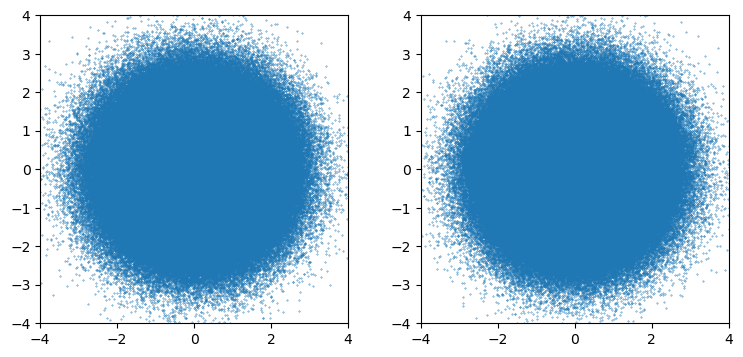

In [269]:
N = 1000000
U1 = np.random.rand(N)
U2 = np.random.rand(N)
Th = 2 * np.pi * U1
R = np.sqrt(-2.*np.log(U2))
x = R * np.cos(Th)
y = R * np.sin(Th)
plt.figure(figsize=(9,4))
plt.subplot(1,2,1, aspect='equal')
plt.scatter(x, y, s=0.1)

plt.xlim(-4, 4)
plt.ylim(-4, 4)
plt.subplot(1,2,2, aspect='equal')
dots = np.random.multivariate_normal([0, 0], [[1, 0], [0, 1]], N)
plt.scatter(dots[:, 0], dots[:, 1], s=0.1)
plt.xlim(-4, 4)
plt.ylim(-4, 4)
plt.show()

We can also plot the colorbar 2D plot to see the density distribution more clearly. And 1D plots in x=0 and y=0. And it indeed looks like a gaussian.
Plots are not smooth because of my algorith to round dots. Could have come up with something better I guess.

1718.0


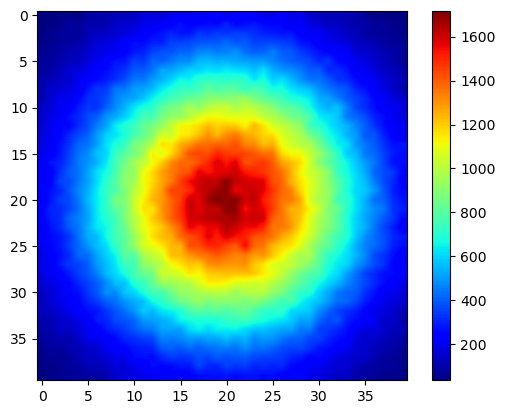

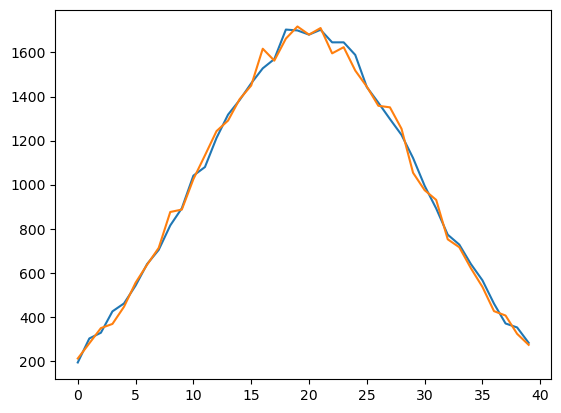

In [270]:
x_r = (np.round(x, 1) * 10).astype(int)
x_r = x_r[-20 <= x_r]
x_r = x_r[x_r < 20] + 20
y_r = (np.round(y, 1) * 10).astype(int)
y_r = y_r[-20 <= y_r]
y_r = y_r[y_r < 20] + 20
Ampl = np.ones((40, 40))
for i, j in zip(x_r, y_r):
	Ampl[i, j] += 1
print(Ampl.max())

plt.imshow(Ampl, cmap='jet', interpolation='bilinear')
plt.colorbar()
plt.show()
plt.plot(Ampl[:, 20])
plt.plot(Ampl[20, :])
plt.show()

***************************************
***************************************
***Problem 4: Singular Value Decomposition (bonus 15pts)***

Let's use images from MNIST since we have already downloaded them.

The plots of original images:

torch.Size([6, 1, 28, 28])


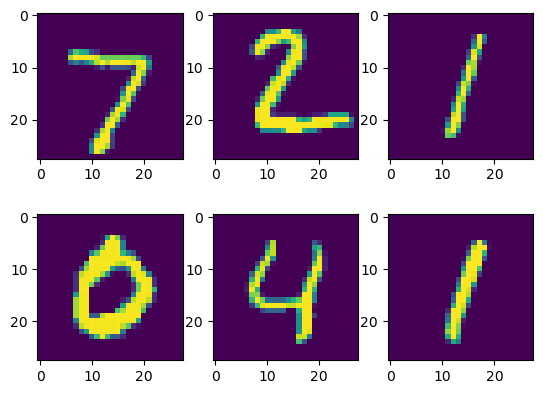

In [271]:
images_six = X_test_T[0:6]
print(images_six.shape)
images_six = images_six.reshape([6, 28, 28])
for i in range(images_six.shape[0]):
	plt.subplot(2, 3, i + 1)
	plt.imshow(images_six[i])
plt.show()

Let's create our own SVD algorithm. As a reference, I am using wikipedia page about the Singular Value decomposition:
The columns of $V$ (referred to as right-singular vectors) are eigenvectors of $A^TA$.
The non-zero elements of $\Sigma$ (non-zero singular values) are the square roots of the non-zero eigenvalues of $A^TA$.
And $U$ we calculate from $A = U * \Sigma * V^T$: $U = AV\Sigma^{-1}$

In [339]:
def svd(A):
	"""
	Compute the SVD of matrix A.
	"""
	# Eigen decomposition of A^TA. The eigenvalues in ascending order
	eigenvalues_V, eigenvectors_V = np.linalg.eigh(np.dot(A.T, A))
	# The singular values are the square roots of the eigenvalues of A^TA
	eigenvalues_V[eigenvalues_V < 0] = 0  # rounding makes some 0s small negative numbers
	singular_values = np.sqrt(eigenvalues_V)[::-1]

	# Order the eigenvectors to correspond to descending singular values
	V = eigenvectors_V[:, ::-1]

	# Compute U using the relationship U = AV/Sigma
	# since we are using division by the vector Sigma (not full \Sigma^{-1}), we have to avoid division by 0.
	# For that the threshold value is used
	threshold = 1e-10
	singular_values[singular_values < threshold] = 1.0  # Set these values temporarily to 1
	U = np.dot(A, V)
	U = U / singular_values
	singular_values[singular_values < threshold] = 0.0  # Set them back to zero

	return U, np.diag(singular_values), V.T

Now let's make the compression and decompression algorithms.

In [331]:
def compress_image(img, k):
	# Perform SVD
	U, Sigma, VT = svd(img)
	# Retain only top k values
	U_k = U[:, :k]
	Sigma_k = Sigma[:k, :k]
	VT_k = VT[:k, :]

	return U_k, Sigma_k, VT_k

def decompress_image(U_k, Sigma_k, VT_k):
    return np.dot(U_k, np.dot(Sigma_k, VT_k))

If for 6 images of size $n*N$ each ($6*n*n$ total) we want to have $3*n*n$ total compressed values, we need the following k number:
Total values: $(n*k + k*k + k*n) * 6 = k*(2*n+k) * 6$.
Thus, we need to solve the following inequality:
$$6k(2n+k) <= 3n^2,$$
$$6k^2+12kn-3n^2<=0,$$
$$2k^2+4kn-n^2<=0,$$
solving it we getting
$$k <= n(-1 + \sqrt(2).$$
In our case $n=28$ so k should be less than 11.6.

Now we can compress and plot all 6 images for different K values. Let's try K=10 and K=5.

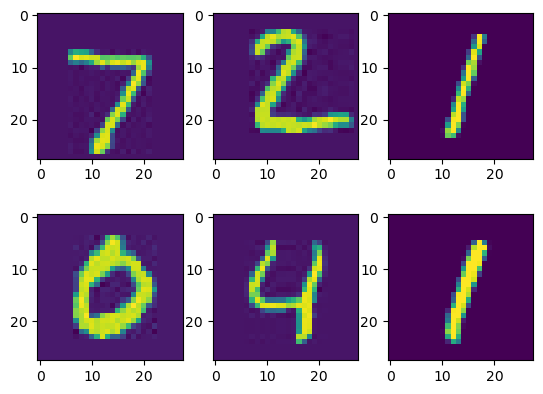

In [345]:
K = 10
compressed_images = [compress_image(image, K) for image in images_six]
decompresses_images =  [decompress_image(*compressed_image) for compressed_image in compressed_images]
for i in range(images_six.shape[0]):
	plt.subplot(2, 3, i + 1)
	plt.imshow(decompresses_images[i])
plt.show()

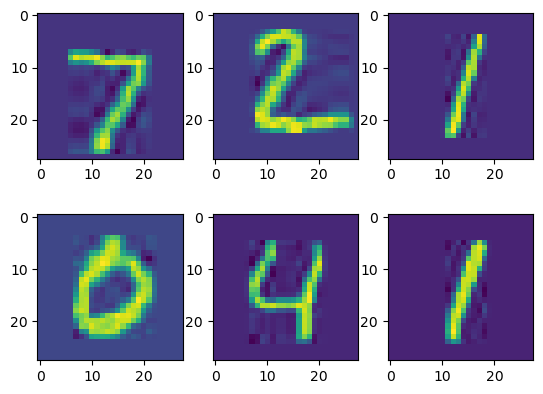

In [343]:
K = 5
compressed_images = [compress_image(image, K) for image in images_six]
decompresses_images =  [decompress_image(*compressed_image) for compressed_image in compressed_images]
for i in range(images_six.shape[0]):
	plt.subplot(2, 3, i + 1)
	plt.imshow(decompresses_images[i])
plt.show()

Interesting, that the background is getting darker (values rising from 0) when the number of dimensions is very low (5)